<a href="https://colab.research.google.com/github/VishwasGajawada/ascii-filter/blob/master/ascii_filter_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless


In [ ]:
from google.colab import files
uploaded = files.upload()

import cv2
import numpy as np
import io
from PIL import Image

# Get image from uploaded dict
filename = next(iter(uploaded))  # gets the first (and usually only) file

# Read the image using OpenCV
img_bytes = uploaded[filename]
image = Image.open(io.BytesIO(img_bytes)).convert('RGB')
img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)


Saving maxresdefault.jpg to maxresdefault.jpg


In [ ]:
# Resize image to terminal-friendly size
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, (100, int(gray.shape[0] * 100 / gray.shape[1] / 2)))

# ASCII characters for brightness and edges
brightness_chars = "@%#*+=-:. "
edge_chars = {
    (0, 22.5): '_', (22.5, 67.5): '/', (67.5, 112.5): '|',
    (112.5, 157.5): '\\', (157.5, 202.5): '_', (202.5, 247.5): '/',
    (247.5, 292.5): '|', (292.5, 337.5): '\\', (337.5, 360): '_'
}

def angle_to_ascii(angle):
    for (low, high), char in edge_chars.items():
        if low <= angle < high:
            return char
    return '_'

# Precompute brightness-based ASCII
ascii_img = [
    [brightness_chars[pixel * (len(brightness_chars)-1) // 255] for pixel in row]
    for row in gray
]

# Apply Difference of Gaussians
blur1 = cv2.GaussianBlur(gray, (3, 3), 0.5)
blur2 = cv2.GaussianBlur(gray, (5, 5), 1.0)
dog = cv2.absdiff(blur1, blur2)

# Sobel gradients on DoG
gx = cv2.Sobel(dog, cv2.CV_64F, 1, 0, ksize=3)
gy = cv2.Sobel(dog, cv2.CV_64F, 0, 1, ksize=3)
mag = np.sqrt(gx ** 2 + gy ** 2)
angle = (np.arctan2(gy, gx) * 180 / np.pi) % 360

# Merge edge map and brightness-based ASCII
threshold = 30
final_output = []
for y in range(gray.shape[0]):
    line = ""
    for x in range(gray.shape[1]):
        if mag[y, x] > threshold:
            line += angle_to_ascii(angle[y, x])
        else:
            line += ascii_img[y][x]
    final_output.append(line)

# Print result
for line in final_output:
    print(line)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@_@@@@_@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@\@@@/@@@\||||@@@@@@@@@_@||\@@@@||||||/@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@/|@@_@@/@@@@@@|||@@@@@@@@@\_|\|@_@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@|||@@@@@@@@@@@@@@@@_/|\@/@@@/@@/|@@@@@\@@@@@@@__|_@@_@@@@@@@@@@@@@@@/@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@__/\__@@//||@@@@@@@@@||@@@@@\||||@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@/@@@@@@@@@@@@@@@@@@@___\\@|/@@@@@@@@@@@@@@@@@@@@@\/|||@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@//|\||@@@@@@@@@@@@@@@___\\\\||@_@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@_/|\_/@|/@@@@@@@@@@@@__\|/_@%@@_@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@\\\__@@@@@@@@@@@@@@@@\\_@@_@@|\\||@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@/@@|\\//@@@@@@@@@@@@@@@@@__\__@_/\||\\@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

<ipython-input-3-f107a10648cd>:21: RuntimeWarning: overflow encountered in scalar multiply
  [brightness_chars[pixel * (len(brightness_chars)-1) // 255] for pixel in row]


In [ ]:
#@title 🖼️ Interactive ASCII Art Generator (AcerolaFX-style)
#@markdown Run this cell. First, choose your image source. Then, adjust the parameters below to see the effect in real-time.

# Step 1: Install and import necessary libraries (only runs once)
try:
    import cv2
    import numpy as np
    from PIL import Image
    import requests
    import io
    import os
    import matplotlib.pyplot as plt
    from google.colab import files
except ImportError:
    print("Installing necessary libraries...")
    !pip install opencv-python-headless numpy Pillow requests
    print("Installation complete. Please re-run this cell.")
    # This import is repeated to ensure they are available after install
    import cv2
    import numpy as np
    from PIL import Image
    import requests
    import io
    import matplotlib.pyplot as plt
    from google.colab import files


# Step 2: Interactive Parameters using Colab Forms

# --- Image Source ---
image_source = 'Upload Custom Image'  #@param ["Sample URL", "Upload Custom Image"]
sample_url = 'https://images.unsplash.com/photo-1534528741775-53994a69daeb?w=800'  #@param ["https://images.unsplash.com/photo-1534528741775-53994a69daeb?w=800", "https://images.unsplash.com/photo-1507525428034-b723a9ce6890?w=800", "https://images.unsplash.com/photo-1528459801416-a9e53bbf4e17?w=800", "https://images.unsplash.com/photo-1617294255533-01648e1a5d5b?w=800"]

# --- Preprocess Settings ---
print("--- Preprocess Settings ---")
Sigma = 2.6  #@param {type:"slider", min:0.1, max:5.0, step:0.1}
SigmaScale = 1.8  #@param {type:"slider", min:1.0, max:5.0, step:0.1}
Tau = 1.1 # @param {"type":"slider","min":0.1,"max":2,"step":0.1}
Threshold = 0.01  #@param {type:"slider", min:0.001, max:0.1, step:0.001}
EdgeThreshold = 19 #@param {type:"slider", min:1, max:64, step:1}

# --- Color & Style Settings ---
print("\n--- Color & Style Settings ---")
Edges = True #@param {type:"boolean"}
Fill = True #@param {type:"boolean"}
InvertLuminance = False #@param {type:"boolean"}
ASCIIColor_hex = "#FFFFFF" #@param {type:"string"}
BackgroundColor_hex = "#000000" #@param {type:"string"}
BlendWithBase = 0 #@param {type:"slider", min:0, max:1, step:0.05}

# Step 3: Helper functions
def hex_to_bgr(hex_color):
    """Converts a hex color string to a BGR list for OpenCV."""
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return list(reversed(rgb)) # Return as BGR list

def load_image_from_url(url):
    """Downloads an image and returns it as a NumPy array (BGR)."""
    try:
        response = requests.get(url)
        response.raise_for_status()
        return load_image_from_bytes(response.content)
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        return None

def load_image_from_bytes(image_bytes):
    """Loads an image from bytes and returns it as a NumPy array (BGR)."""
    try:
        pil_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
        return cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    except Exception as e:
        print(f"Error processing image bytes: {e}")
        return None

# --- Core Logic Functions (from previous implementation) ---
def difference_of_gaussians(image, sigma, sigma_scale, tau, threshold):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    ksize = int(6 * sigma + 1) | 1
    blur1 = cv2.GaussianBlur(gray, (ksize, ksize), sigma)
    ksize2 = int(6 * sigma * sigma_scale + 1) | 1
    blur2 = cv2.GaussianBlur(gray, (ksize2, ksize2), sigma * sigma_scale)
    dog = blur1 - tau * blur2
    _, edge_map = cv2.threshold(dog, threshold, 1.0, cv2.THRESH_BINARY)
    return edge_map

def calculate_sobel_gradients(edge_map):
    gx = cv2.Sobel(edge_map, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(edge_map, cv2.CV_32F, 0, 1, ksize=3)
    theta = np.arctan2(gy, gx)
    edge_mask = np.sqrt(gx**2 + gy**2) > 0.001
    return theta, edge_mask


--- Preprocess Settings ---

--- Color & Style Settings ---


In [ ]:
# OLD

def render_ascii(source_img, theta, edge_mask, edges_lut, fill_lut, p):
    h, w, _ = source_img.shape
    output_canvas = np.zeros_like(source_img)
    gray_source = cv2.cvtColor(source_img, cv2.COLOR_BGR2GRAY)

    for y in range(0, h - 7, 8):
        for x in range(0, w - 7, 8):
            theta_tile, mask_tile = theta[y:y+8, x:x+8], edge_mask[y:y+8, x:x+8]
            valid_thetas = theta_tile[mask_tile]
            char_tile = np.zeros((8, 8, 3), dtype=np.uint8)

            if p['Edges'] and len(valid_thetas) > p['EdgeThreshold']:
                directions = np.zeros_like(valid_thetas, dtype=int)
                pi = np.pi
                abs_thetas = np.abs(valid_thetas)
                directions[(abs_thetas < pi * 0.25) | (abs_thetas > pi * 0.75)] = 1
                directions[(valid_thetas > pi * 0.25) & (valid_thetas < pi * 0.75)] = 3
                directions[(valid_thetas < -pi * 0.25) & (valid_thetas > -pi * 0.75)] = 2
                counts = np.bincount(directions, minlength=4)
                lut_index = np.argmax(counts)
                if lut_index == 0: lut_index = 1
                elif lut_index == 1: lut_index = 0
                char_x = (lut_index + 1) * 8
                char_tile = edges_lut[0:8, char_x:char_x+8]
            elif p['Fill']:
                avg_lum = np.mean(gray_source[y:y+8, x:x+8]) / 255.0
                if p['InvertLuminance']: avg_lum = 1.0 - avg_lum
                lum_index = min(9, int(np.floor(avg_lum * 10)))
                char_x = lum_index * 8
                char_tile = fill_lut[0:8, char_x:char_x+8]

            char_mask = cv2.cvtColor(char_tile, cv2.COLOR_BGR2GRAY) > 0
            colored_tile = np.full_like(char_tile, p['BackgroundColor'])

            ascii_color_array = np.full_like(char_tile, p['ASCIIColor'])
            if p['BlendWithBase'] > 0:
                base_color_tile = source_img[y:y+8, x:x+8]
                blended_color = cv2.addWeighted(ascii_color_array, 1 - p['BlendWithBase'], base_color_tile, p['BlendWithBase'], 0)
                colored_tile[char_mask] = blended_color[char_mask]
            else:
                colored_tile[char_mask] = p['ASCIIColor']

            output_canvas[y:y+8, x:x+8] = colored_tile
    return output_canvas

In [ ]:
# --- NEW: Define the ASCII character sets as lists of strings ---
# Based on your description of edgesASCII.png
# Order: Blank, Vertical, Horizontal, Diag1 (forward slash), Diag2 (backslash)
EDGE_CHARS = [
    ' ', # Placeholder for blank (commonEdgeIndex could be -1)
    '|', # Vertical
    '-', # Horizontal
    '/', # Diag1 (forward slash)
    '\\' # Diag2 (backslash)
]

# Based on your description of fillASCII.png
# Order: Darkest to Brightest
FILL_CHARS = [' ', '.', ';', 'c', 'o', 'P', 'O', '?', 'e', '■'] # The '█' is a solid block character

def render_ascii_text(source_img, theta, edge_mask, p):
    """
    Renders the ASCII art as a list of strings (text).
    This function no longer needs edges_lut or fill_lut (PNG images).
    """
    h, w, _ = source_img.shape
    # Create a list of lists to build the ASCII art character by character
    ascii_rows = [[' ' for _ in range((w // 8)*2)] for _ in range(h // 8)]

    gray_source = cv2.cvtColor(source_img, cv2.COLOR_BGR2GRAY)

    for y_block in range(h // 8):
        for x_block in range(w // 8):
            y_start, y_end = y_block * 8, (y_block + 1) * 8
            x_start, x_end = x_block * 8, (x_block + 1) * 8

            theta_tile = theta[y_start:y_end, x_start:x_end]
            mask_tile = edge_mask[y_start:y_end, x_start:x_end]
            valid_thetas = theta_tile[mask_tile]

            chosen_char = ' ' # Default to space

            if p['Edges'] and len(valid_thetas) > p['EdgeThreshold']:
                directions = np.zeros_like(valid_thetas, dtype=int)
                pi = np.pi

                # Re-evaluate the mapping to match your specific char types
                # 0: Vertical, 1: Horizontal, 2: Diag /, 3: Diag \
                for i, angle in enumerate(valid_thetas):
                    abs_angle = abs(angle)
                    if (abs_angle < pi/8) or (abs_angle > 7*pi/8): # Vertical-ish
                        directions[i] = 0 # Maps to '|'
                    elif (abs_angle > 3*pi/8) and (abs_angle < 5*pi/8): # Horizontal-ish
                        directions[i] = 1 # Maps to '-'
                    elif (angle > pi/8) and (angle < 3*pi/8): # Positive slope diagonal (forward slash '/')
                        directions[i] = 2
                    elif (angle < -pi/8) and (angle > -3*pi/8): # Negative slope diagonal (backslash '\')
                        directions[i] = 3

                counts = np.bincount(directions, minlength=4)
                if np.sum(counts) > 0: # Ensure there were actual votes
                    common_edge_index = np.argmax(counts)
                    chosen_char = EDGE_CHARS[common_edge_index + 1] # +1 because EDGE_CHARS has blank at index 0

            elif p['Fill']:
                # Get average luminance for the tile
                luminance_tile = gray_source[y_start:y_end, x_start:x_end]
                avg_lum = np.mean(luminance_tile) / 255.0

                if p['InvertLuminance']:
                    avg_lum = 1.0 - avg_lum

                # Quantize luminance to one of 10 levels (0-9)
                lum_index = min(len(FILL_CHARS) - 1, max(0, int(np.floor(avg_lum * len(FILL_CHARS)))))
                chosen_char = FILL_CHARS[lum_index]

            ascii_rows[y_block][x_block*2] = chosen_char

    # Join the characters to form lines of text
    final_ascii_text = ["".join(row) for row in ascii_rows]
    return final_ascii_text


# --- NEW: Function to visualize ASCII text as an image ---
def visualize_ascii_as_image(ascii_text_lines, char_width=8, char_height=8, p=None):
    """
    Renders ASCII text lines as a pixel image for visual display,
    applying colors based on parameters.
    """
    if not ascii_text_lines:
        return np.zeros((char_height, char_width, 3), dtype=np.uint8) # Return a small black image

    # Assuming monospaced font
    height_px = len(ascii_text_lines) * char_height
    width_px = len(ascii_text_lines[0]) * char_width

    img = Image.new('RGB', (width_px, height_px), tuple(reversed(p['BackgroundColor']))) # PIL uses RGB

    from PIL import ImageDraw, ImageFont
    try:
        # Try to load a monospaced font
        font = ImageFont.truetype("DejaVuSansMono.ttf", char_height)
    except IOError:
        # Fallback to a default font if DejaVuSansMono isn't available
        # On Colab, usually FreeMono.ttf or a similar one is present
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", char_height)
        except IOError:
            print("Warning: Monospaced font not found. Using default PIL font.")
            font = ImageFont.load_default()
            char_width = font.getsize(" ")[0] # Recalculate char_width for default font

    draw = ImageDraw.Draw(img)

    for r_idx, line in enumerate(ascii_text_lines):
        for c_idx, char in enumerate(line):
            x = c_idx * char_width
            y = r_idx * char_height
            # Use ASCIIColor for the character, BackgroundColor for the background of the char cell
            draw.text((x, y), char, font=font, fill=tuple(reversed(p['ASCIIColor'])))
            # If blend with base was active, you'd need the original pixel color here
            # But the blend is complex as it depends on the original image's pixel color, which isn't available per char directly here

    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR) # Convert back to OpenCV BGR


In [ ]:
 # --- Load assets (LUTs) ---
edges_lut_url = "https://raw.githubusercontent.com/GarrettGunnell/AcerolaFX/refs/heads/main/Textures/edgesASCII.png"
fill_lut_url = "https://raw.githubusercontent.com/GarrettGunnell/AcerolaFX/refs/heads/main/Textures/fillASCII.png"
edges_lut = load_image_from_url(edges_lut_url)
fill_lut = load_image_from_url(fill_lut_url)



Please upload an image file.


Saving Screenshot 2025-06-02 160329.png to Screenshot 2025-06-02 160329.png

Processing uploaded file: 'Screenshot 2025-06-02 160329.png'

1. Resizing image for processing...
2. Performing Difference of Gaussians edge detection...
3. Calculating Sobel gradients for edge direction...
4. Rendering final ASCII image...

Done! Displaying results below.


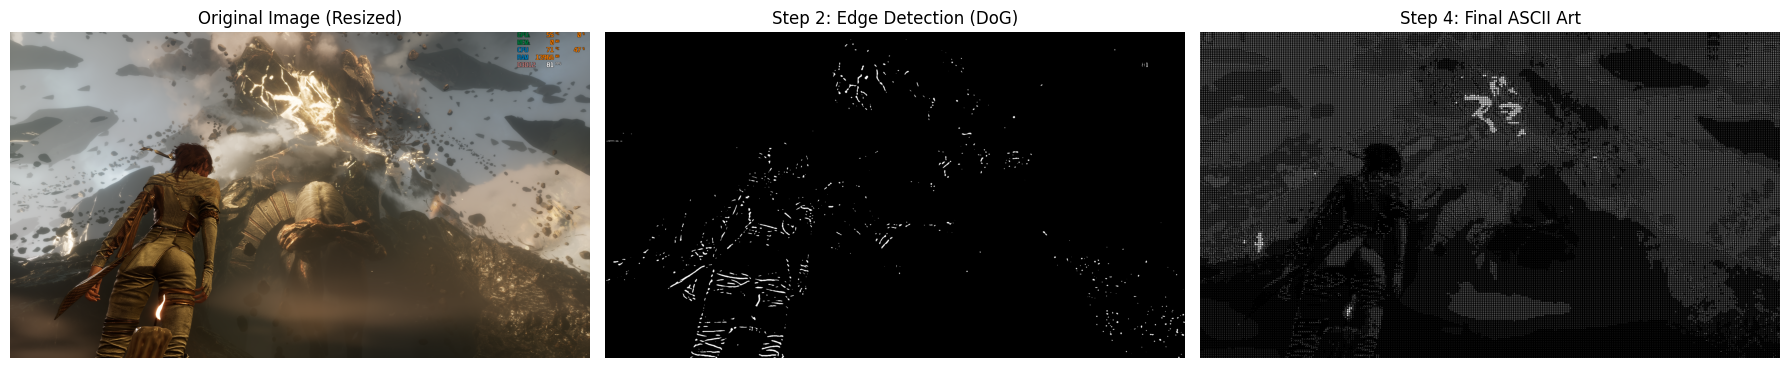


ASCII art saved to 'Screenshot 2025-06-02 160329_ascii_art.txt'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download should have started. Check your browser's download manager.


In [ ]:
# Step 4: Main Execution Block
source_image = None
if image_source == 'Upload Custom Image':
    print("\nPlease upload an image file.")
    uploaded = files.upload()
    if uploaded:
        filename = next(iter(uploaded))
        base_name = os.path.splitext(filename)[0]
        output_filename = f"{base_name}_ascii_art.txt"
        print(f"\nProcessing uploaded file: '{filename}'")
        source_image = load_image_from_bytes(uploaded[filename])
    else:
        print("\nNo file uploaded. Please upload a file to see the result.")
else: # Sample URL
    print(f"\nLoading sample image from URL...")
    source_image = load_image_from_url(sample_url)

if source_image is not None:
    if edges_lut is not None and fill_lut is not None:
        # --- Package parameters for the render function ---
        params = {
            'EdgeThreshold': EdgeThreshold,
            'Edges': Edges, 'Fill': Fill, 'InvertLuminance': InvertLuminance,
            'ASCIIColor': hex_to_bgr(ASCIIColor_hex),
            'BackgroundColor': hex_to_bgr(BackgroundColor_hex),
            'BlendWithBase': BlendWithBase
        }

        # --- Run the full pipeline ---
        print("\n1. Resizing image for processing...")
        h, w, _ = source_image.shape
        new_h, new_w = (h // 8) * 8, (w // 8) * 8
        resized_image = cv2.resize(source_image, (new_w, new_h))

        print("2. Performing Difference of Gaussians edge detection...")
        dog_edges = difference_of_gaussians(resized_image, Sigma, SigmaScale, Tau, Threshold)

        print("3. Calculating Sobel gradients for edge direction...")
        theta, edge_mask = calculate_sobel_gradients(dog_edges)

        print("4. Rendering final ASCII image...")
        final_ascii_art = render_ascii(resized_image, theta, edge_mask, edges_lut, fill_lut, params)
        print("\nDone! Displaying results below.")

        # --- Display Results ---
        plt.figure(figsize=(18, 9))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image (Resized)')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(dog_edges, cmap='gray')
        plt.title('Step 2: Edge Detection (DoG)')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(final_ascii_art, cv2.COLOR_BGR2RGB))
        plt.title('Step 4: Final ASCII Art')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        final_ascii_text_lines = render_ascii_text(resized_image, theta, edge_mask, params)
        # --- Save to Text File and Prompt Download ---
        # output_filename = "ascii_art_output.txt"
        try:
            with open(output_filename, "w") as f:
                for line in final_ascii_text_lines:
                    f.write(line + "\n")
            print(f"\nASCII art saved to '{output_filename}'.")
            files.download(output_filename) # This will trigger the download prompt
            print("Download should have started. Check your browser's download manager.")
        except Exception as e:
            print(f"Error saving or downloading file: {e}")
            print("\n--- ASCII Art (Printed to Console) ---")
            for line in final_ascii_text_lines:
                print(line)
            print("------------------------------------------")